# Understanding and mitigating distribution inference attacks

In this notebook, we present the code relative to the different experiments from the paper.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from experiments import experiment_a, experiment_abis, experiment_b, experiment_c, experiment_causal
import os
from os import mkdir
from os.path import join, exists

from scipy.stats import ttest_ind

In [2]:
RESULTS_FOLDER = os.path.join(os.getcwd(), 'results')
FIGURES_FOLDER = os.path.join(os.getcwd(), 'figures')

In [3]:
if not exists(RESULTS_FOLDER):
    mkdir(RESULTS_FOLDER)
    
if not exists(FIGURES_FOLDER):
    mkdir(FIGURES_FOLDER)

In [4]:
sns.set_theme(palette=sns.color_palette('YlOrRd_r', 3))
sns.set_context('notebook', font_scale=2.5)

def plot(df, x, y, filename, col = None, xlabel = None, ylabel = None):
    if col is not None and df[col].nunique() > 1:
        n_cols = df[col].nunique()
        _, axs = plt.subplots(1, n_cols, figsize=(8*n_cols,8), sharey=True)
        df = df.groupby([col, x])[y].agg(('mean', lambda x: np.percentile(x, 2.5), lambda x: np.percentile(x, 97.5)))
        for i, (col, vals) in enumerate(df.groupby(level=0)):
            vals = vals.droplevel(0)
            ax = axs[i]
            error = sns.utils.ci_to_errsize((vals['<lambda_0>'], vals['<lambda_1>']), vals['mean'])
            ax.errorbar(vals.index, vals['mean'], error, color='darkred', ecolor='darkred')
            ax.set_xlabel(x if xlabel is None else xlabel)
            if i == 0:
                ax.set_ylabel(y if ylabel is None else ylabel)
            if col == 'BlackBox':
                col = 'Black-box'
            elif col == 'WhiteBox':
                col = 'White-box'
            ax.set_title(col)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        
    else:
        df = df.groupby(x)[y].agg(('mean', lambda x: np.percentile(x, 2.5), lambda x: np.percentile(x, 97.5)))
        _, ax = plt.subplots(figsize=(8,8))
        error = sns.utils.ci_to_errsize((df['<lambda_0>'], df['<lambda_1>']), df['mean'])
        ax.errorbar(df.index, df['mean'], error, color='darkred', ecolor='darkred')
        ax.set_xlabel(x if xlabel is None else xlabel)
        ax.set_ylabel(y if ylabel is None else ylabel)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.savefig(join(FIGURES_FOLDER, '{}.pdf'.format(filename)), bbox_inches='tight')
    plt.show()

## Experiment A: Differing conditional distributions

Let $M_0$ a 1-hidden-layer, 32-neurons neural network using the ReLU activation function, with random weights.

We generate $M_1$ as a duplicate of $M_0$ to which we apply independent normal noise $\epsilon$ to every parameter, with $\epsilon \sim N(0, \epsilon^2) ; c \in \mathbb{R}$.

$$\textbf{X} \sim N_4(0, 2 * I_4)$$

We run a binary DeepSets property-inference attack, considering:

$$\mathcal{D}_0 \rightarrow \textbf{Y} = M_0(\textbf{X}) ; \mathcal{D}_1 \rightarrow \textbf{Y} = M_1(\textbf{X})$$

As expected, the higher the value of $\epsilon$, the farther are $M_0$ and $M_1$, and the better the attack accuracy.

In [5]:
FORCE_RUN = False

if not exists(join(RESULTS_FOLDER, 'exp_a_res.pkl')) or FORCE_RUN:
    experiment_a(RESULTS_FOLDER)

### Target model performance

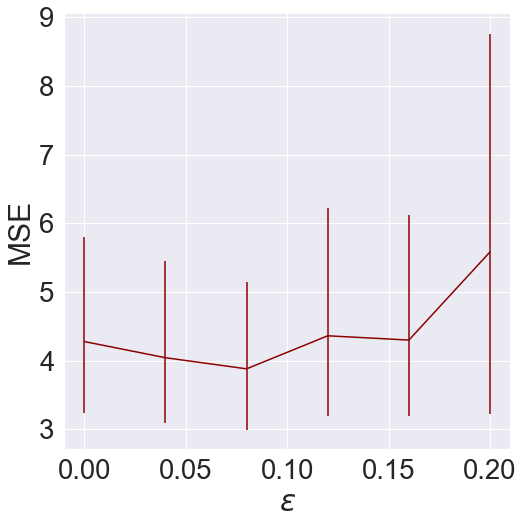

In [6]:
perf = pd.read_pickle(join(RESULTS_FOLDER, 'exp_a_perf.pkl'))
plot(perf, 
     x='epsilon', 
     y='MSE', 
     filename='a_perf', 
     col='Experiment', 
     xlabel='$\\varepsilon$',
     ylabel='MSE'
)

### Property Inference Attack performance

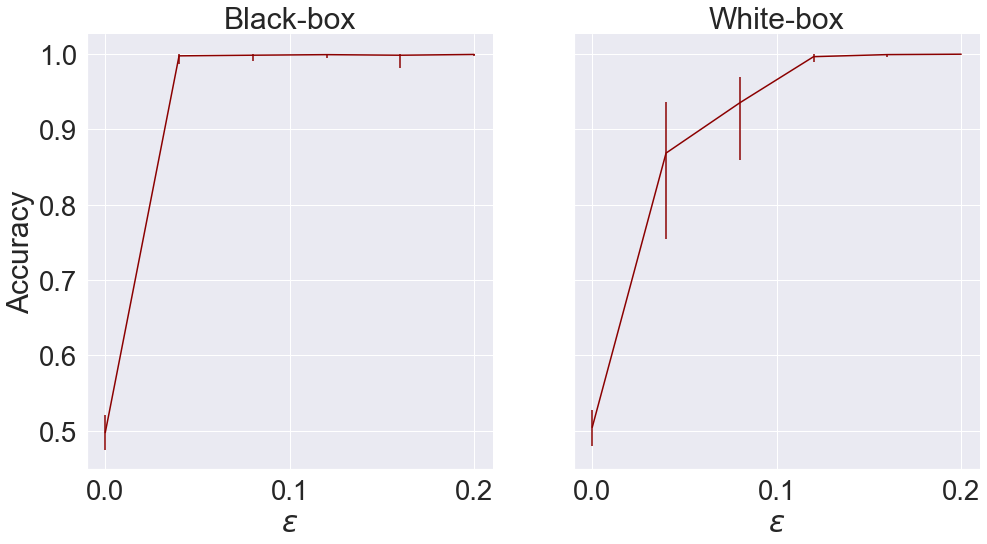

In [7]:
res = pd.read_pickle(join(RESULTS_FOLDER, 'exp_a_res.pkl'))
plot(res, 
     x='epsilon', 
     y='MAE/Acc', 
     filename='a_res', 
     col='Attack', 
     xlabel='$\\varepsilon$',
     ylabel='Accuracy'
)

## Experiment A-bis: Differing conditional distributions with early_stopping

The setting is the same as in Experiment A, with a fixed $\epsilon = 0.05$.

To produce models with a predefined performance, we perform early stopping: we only train the model as long as the training MSE lies above the target MSE, and stop training after the first epoch where it falls below the target MSE.

In [8]:
FORCE_RUN = False

if not exists(join(RESULTS_FOLDER, 'exp_abis_res.pkl')) or FORCE_RUN:
    experiment_abis(RESULTS_FOLDER)

### Target model performance

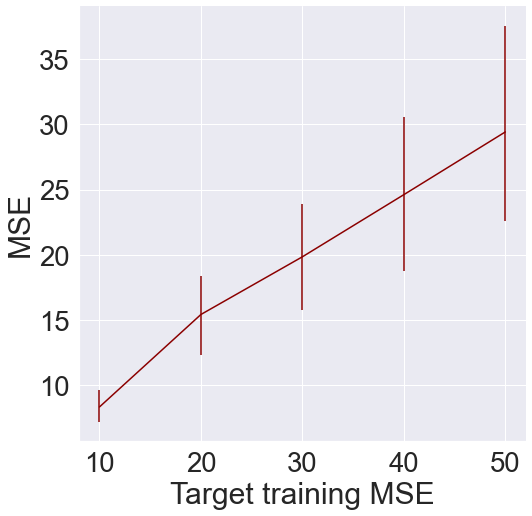

In [9]:
perf = pd.read_pickle(join(RESULTS_FOLDER, 'exp_abis_perf.pkl'))
plot(perf, 
     x='early_stop', 
     y='MSE', 
     filename='abis_perf', 
     col=None, 
     xlabel='Target training MSE',
     ylabel='MSE'
)

### Property Inference Attack performance

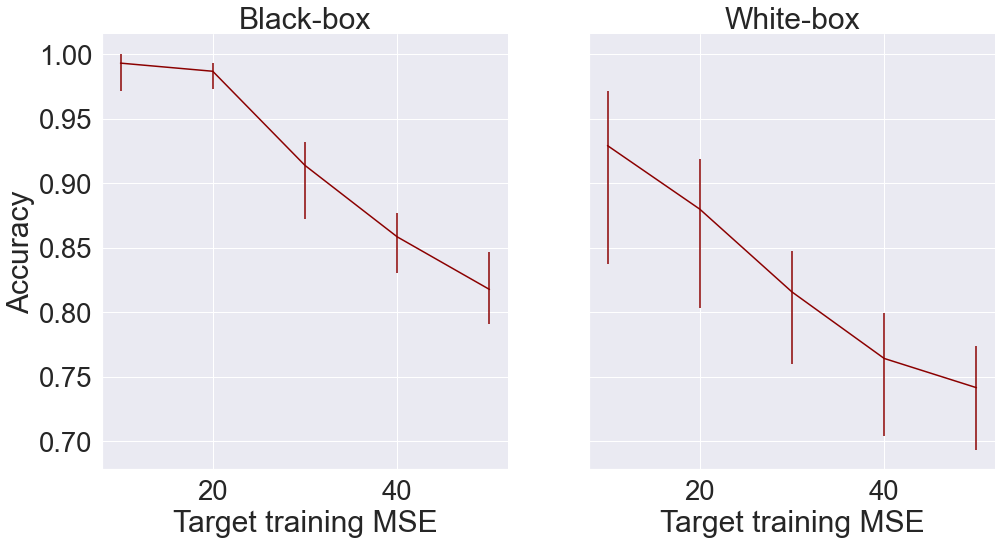

In [10]:
res = pd.read_pickle(join(RESULTS_FOLDER, 'exp_abis_res.pkl'))
plot(res, 
     x='early_stop', 
     y='MAE/Acc', 
     filename='abis_res', 
     col='Attack', 
     xlabel='Target training MSE',
     ylabel='Accuracy'
)

## Experiment B: Model fitness

$$\textbf{X} \sim N_4(-1 + 2*\textit{label}, 2 * I_4)$$

$M$ a 1-hidden-layer, 32-neurons neural network using the ReLU activation function, with random weights.

$$\textbf{Y} = M(\textbf{X})$$

To produce models with a predefined performance, we perform early stopping: we only train the model as long as the training MSE lies above the target MSE, and stop training after the first epoch where it falls below the target MSE.

In [11]:
FORCE_RUN = False

if not exists(join(RESULTS_FOLDER, 'exp_b_res.pkl')) or FORCE_RUN:
    experiment_b(RESULTS_FOLDER)

### Target model performance

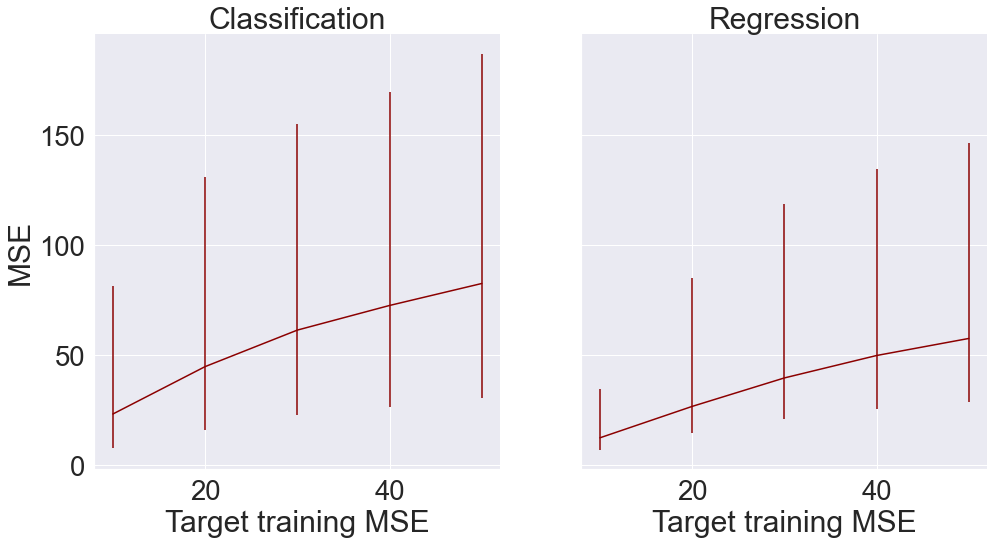

In [12]:
perf = pd.read_pickle(join(RESULTS_FOLDER, 'exp_b_perf.pkl'))
plot(perf, 
     x='early_stop', 
     y='MSE', 
     filename='b_perf', 
     col='Experiment', 
     xlabel='Target training MSE',
     ylabel='MSE'
)

### Property Inference Attack performance

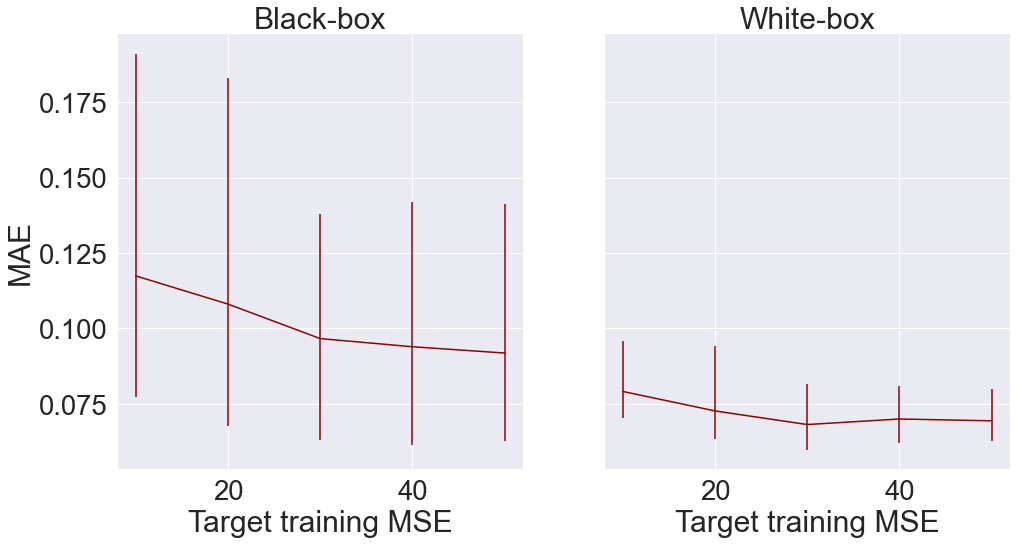

In [13]:
res = pd.read_pickle(join(RESULTS_FOLDER, 'exp_b_res.pkl'))
plot(res[res.Experiment == 'Regression'], 
     x='early_stop', 
     y='MAE/Acc', 
     filename='b_res_reg', 
     col='Attack', 
     xlabel='Target training MSE',
     ylabel='MAE'
)

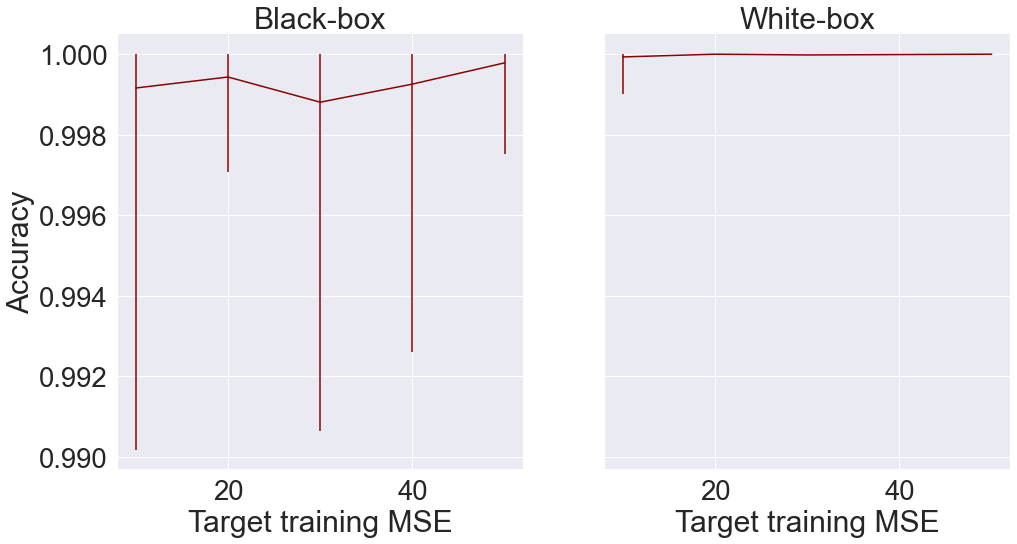

In [14]:
plot(res[res.Experiment == 'Classification'], 
     x='early_stop', 
     y='MAE/Acc', 
     filename='b_res_class', 
     col='Attack', 
     xlabel='Target training MSE',
     ylabel='Accuracy'
)

## Experiment C: Finiteness of the training data

$$\textbf{X} \sim N_4(-1 + 2*\textit{label}, 2 * I_4)$$

$M$ a 1-hidden-layer, 32-neurons neural network using the ReLU activation function, with random weights.

$$\textbf{Y} = M(\textbf{X})$$

Target models have the same architecture as $M$. We run a DeepSets attack for 512, 1024, 1536, 2048 samples in the models' training set. We expect that attack performance drops with a higher number of training samples.

In [15]:
FORCE_RUN = False

if not exists(join(RESULTS_FOLDER, 'exp_c_res.pkl')) or FORCE_RUN:
    experiment_c(RESULTS_FOLDER)

### Target model performance

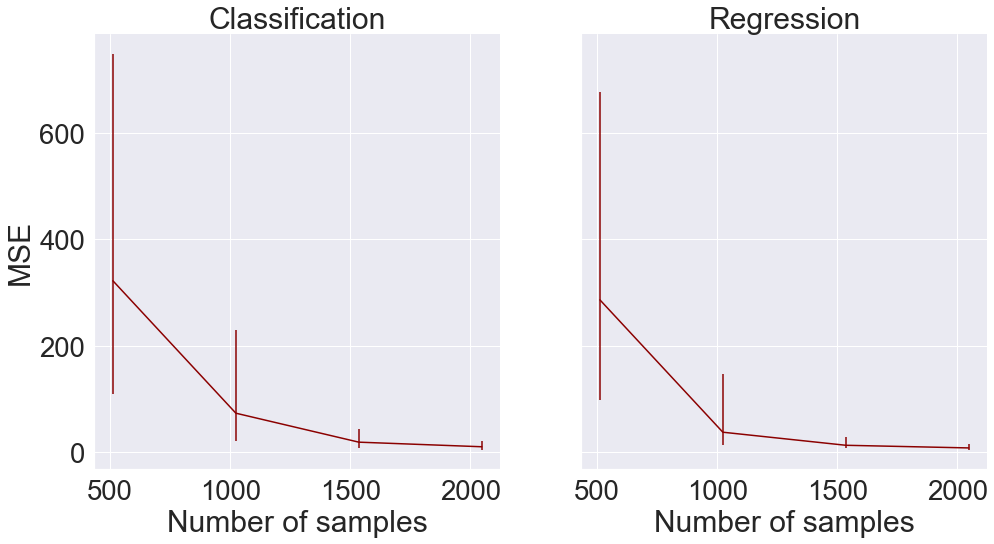

In [16]:
perf = pd.read_pickle(join(RESULTS_FOLDER, 'exp_c_perf.pkl'))
plot(perf, 
     x='n_samples', 
     y='MSE', 
     filename='c_perf', 
     col='Experiment', 
     xlabel='Number of samples',
     ylabel='MSE'
)

### Property Inference Attack performance

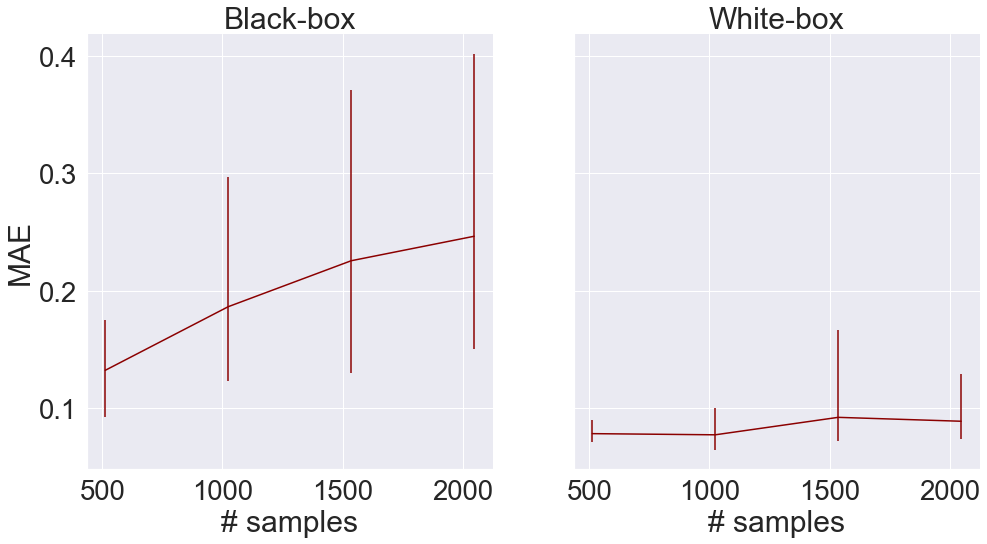

In [17]:
res = pd.read_pickle(join(RESULTS_FOLDER, 'exp_c_res.pkl'))
plot(res[res.Experiment == 'Regression'], 
     x='n_samples', 
     y='MAE/Acc', 
     filename='c_res_reg', 
     col='Attack', 
     xlabel='# samples',
     ylabel='MAE'
)

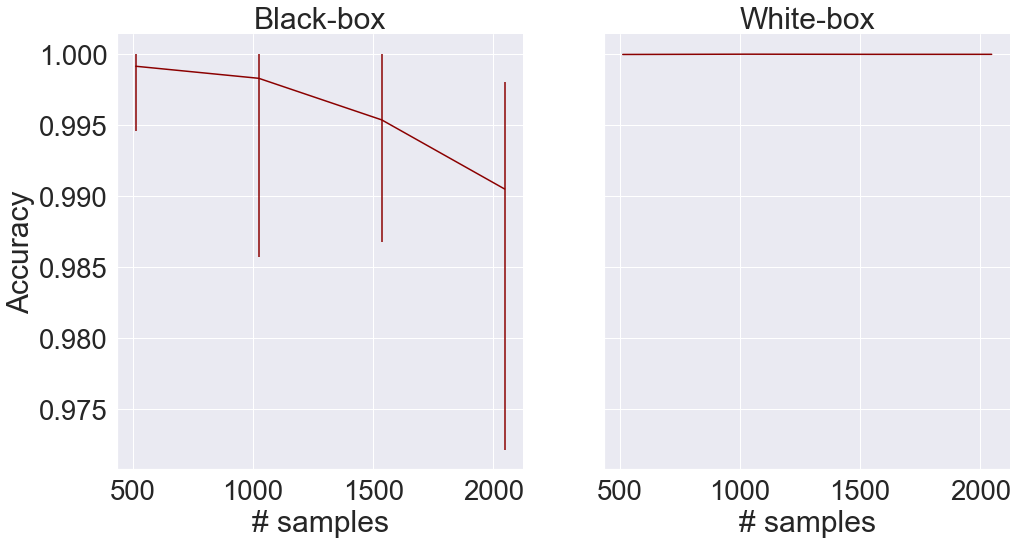

In [18]:
plot(res[res.Experiment == 'Classification'], 
     x='n_samples', 
     y='MAE/Acc', 
     filename='c_res_class', 
     col='Attack', 
     xlabel='# samples',
     ylabel='Accuracy'
)

## Causal Learning Experiment

We generate the data as:

$$X_1^i \sim \mathcal{N}(0, 1)$$
$$Y \sim X_1^i + \mathcal{N}(0, 1)$$
$$X_2^i \sim Y + \mathcal{N}(0, 0.5 + 1*i)$$

with $i$ the indice of the environment. When *label* is True, all environments are included. When it is False, the last environment is not included.

We perform simple DeepSets PIA on ERM, Causal ERM (ERM but with X2 removed) and IRM.

In [19]:
FORCE_RUN = False 

if not exists(join(RESULTS_FOLDER, 'exp_causal_res.pkl')) or FORCE_RUN:
    experiment_causal(RESULTS_FOLDER)

### Target model performance

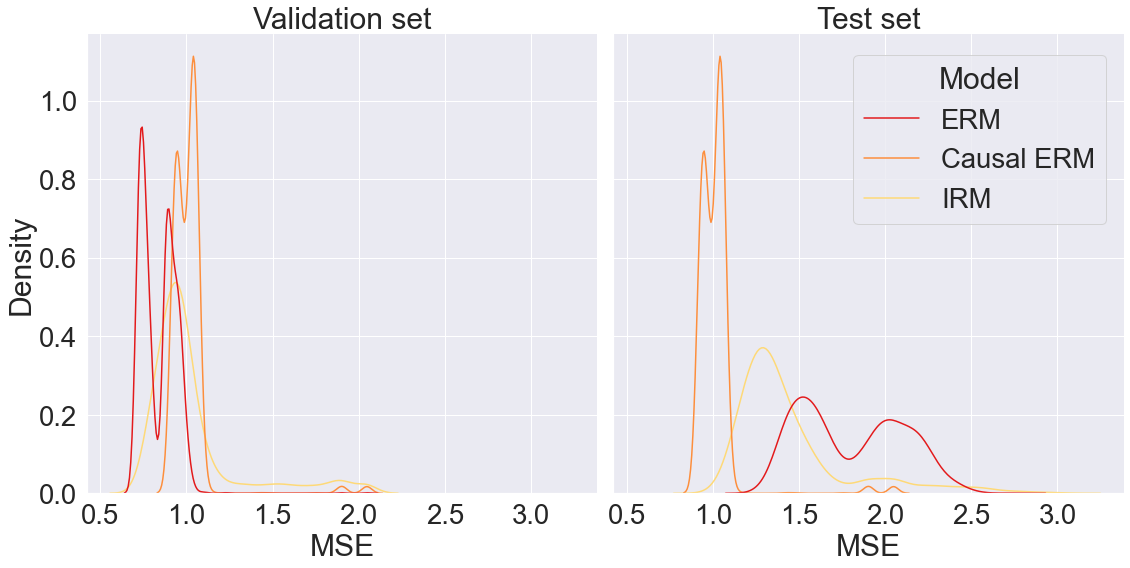

In [20]:
perf = pd.read_pickle(join(RESULTS_FOLDER, 'exp_causal_perf.pkl'))
g = sns.displot(data=perf[perf.Experiment == 'Classification'], hue='Model', x='MSE', col='Set', kind='kde', height=8, aspect=1)

g.fig.axes[0].set_title('Validation set')
g.fig.axes[1].set_title('Test set')
sns.move_legend(obj = g, loc = 'center left', bbox_to_anchor = (0.60, 0.75), frameon=True)
plt.savefig(join(FIGURES_FOLDER, 'causal_perf.pdf'), bbox_inches='tight')
plt.show()

### Property Inference Attack performance

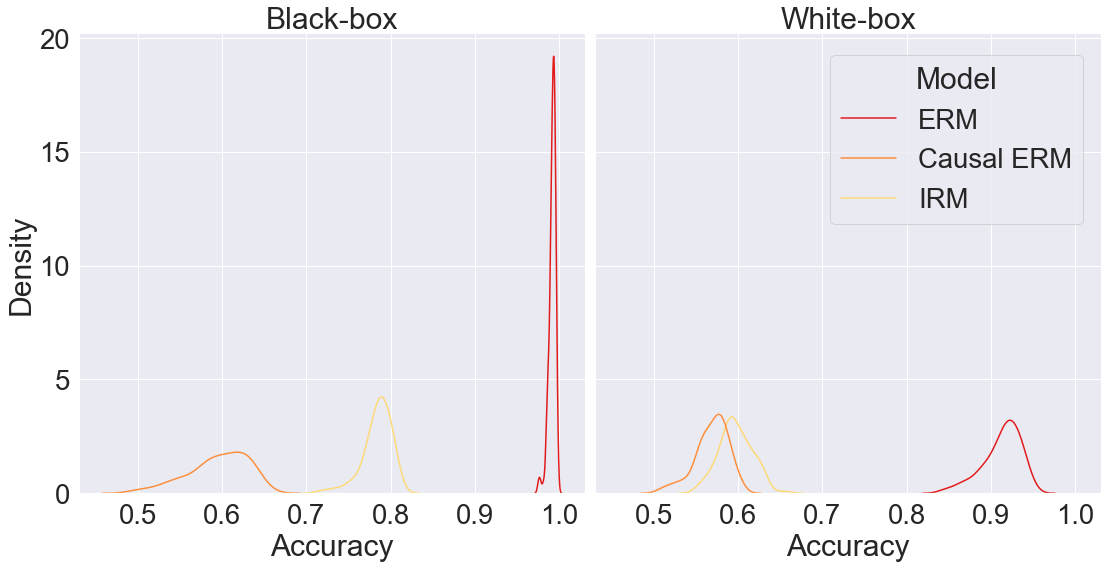

In [21]:
res = pd.read_pickle(join(RESULTS_FOLDER, 'exp_causal_res.pkl'))
g = sns.displot(data=res[res.Experiment == 'Classification'], hue='Model', x='MAE/Acc', col='Attack', kind='kde', col_order=['BlackBox', 'WhiteBox'], height=8, aspect=1)\
       .set(xlabel='Accuracy')

g.fig.axes[0].set_title('Black-box')
g.fig.axes[1].set_title('White-box')
sns.move_legend(obj = g, loc = 'center left', bbox_to_anchor = (0.60, 0.75), frameon=True)
plt.savefig(join(FIGURES_FOLDER, 'causal_res.pdf'), bbox_inches='tight')
plt.show()